# Convolutional Neural Networks (with image augmentation)
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/cifar-cnn/notebook_ims/cifar_data.png' height=70% width=70%>



### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


---
## Load and Augment the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

#### Augmentation

In this cell, we perform some simple [data augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) by randomly flipping and rotating the given image data. We do this by defining a torchvision `transform`, and you can learn about all the transforms that are used to pre-process and augment data [here](https://pytorch.org/docs/stable/torchvision/transforms.html).

#### TODO: Look at the [transforms documentation](https://pytorch.org/docs/stable/torchvision/transforms.html); add more augmentation transforms, and see how your model performs.

This type of data augmentation should add some positional variety to these images so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter what direction it is facing). It is recommended that you choose one or two transforms.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [17]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(), # randomly flip and rotate
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, 
                              transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, 
                             transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices) # modifies sequence in place
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
           'horse', 'ship', 'truck']

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a Batch of Training Data

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img/2 + 0.5
  plt.imshow(np.transpose(img, (1,2,0))) # convert from Tensor image

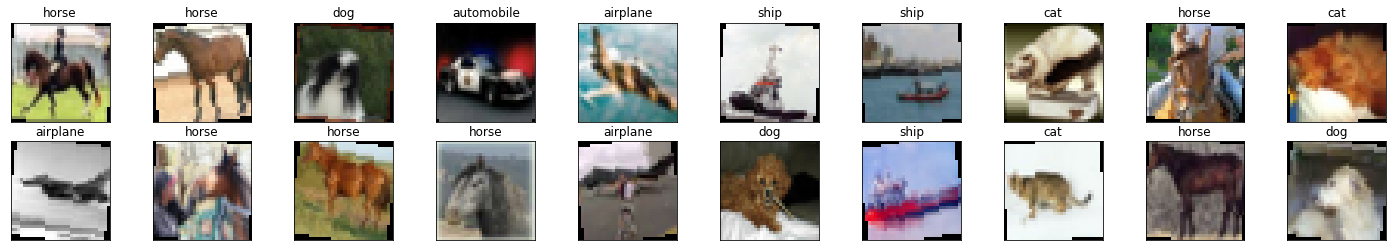

In [19]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized RGB color channels as three separate grayscale intensity images.

In [30]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

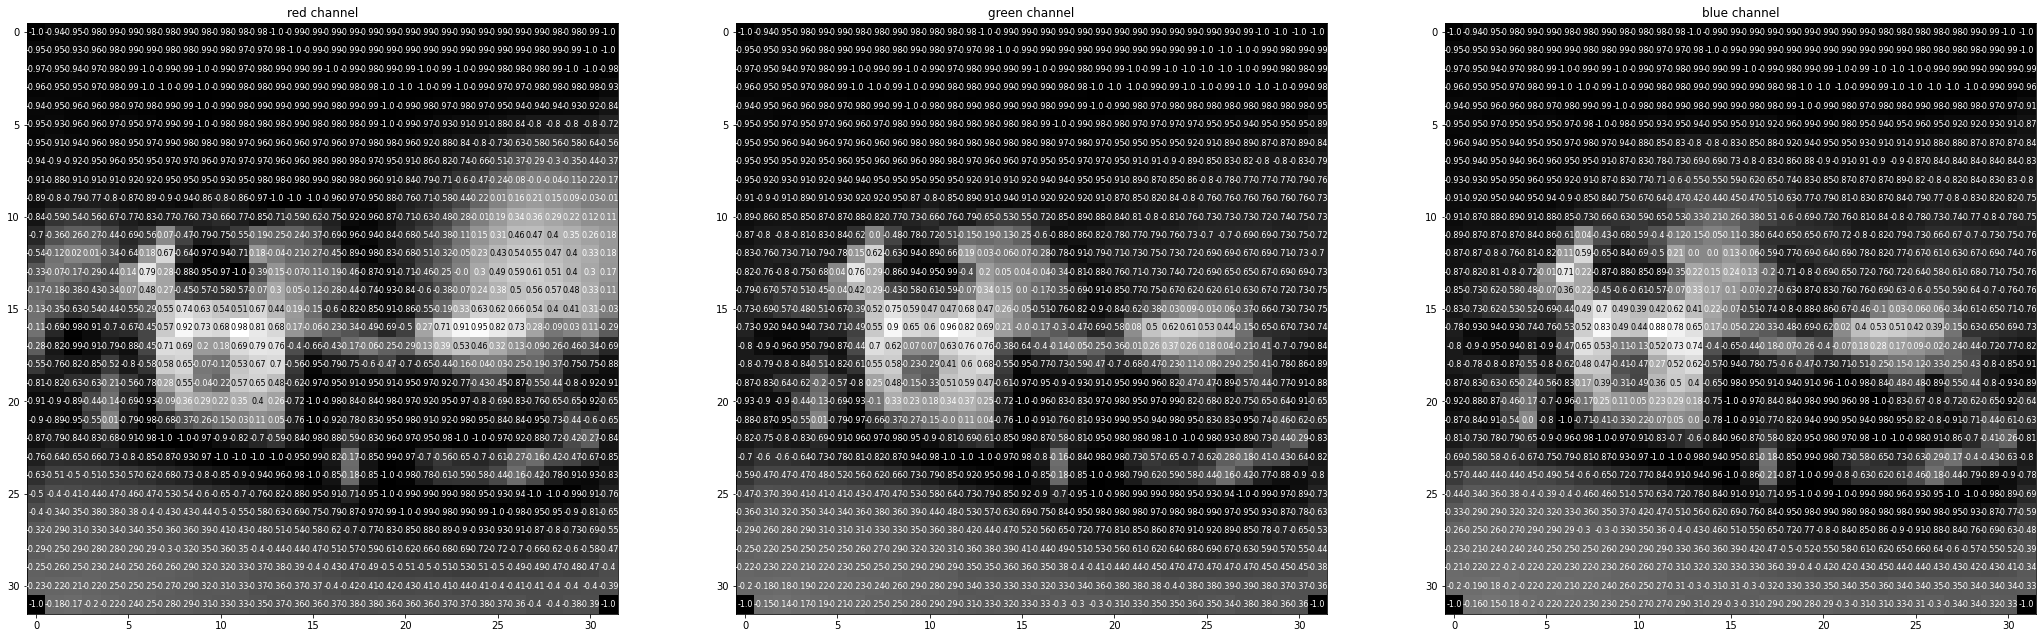

In [31]:
fig = plt.figure(figsize=(36,36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1,3,idx+1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] != 0 else 0
      ax.annotate(str(val), xy=(y,x),
                  horizontalalignment='center',
                  verticalalignment='center', size=8,
                  color='white' if img[x][y]<thresh else 'black')